In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import cv2
import copy
from sklearn import metrics
from torch.autograd import Variable
from PIL import Image
toTensor = transforms.ToTensor
from sklearn.metrics import confusion_matrix

cudnn.benchmark = True
plt.ion() 

In [2]:
model = models.mobilenet_v3_small(pretrained=False)

/home/anim/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/anim/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        # transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda', index=0)

In [5]:
t_loss = []
v_loss = []

actual = []
pred = []
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
#                     outputs = outputs.cpu()
#                     index = outputs.data.numpy().argmax()
#                     pred.append(index)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                t_loss.append(epoch_loss)
            else:
                v_loss.append(epoch_loss)
                
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
torch.cuda.empty_cache()

In [7]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [8]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------


train Loss: 6.4427 Acc: 0.6188
val Loss: 6.4288 Acc: 0.5000

Epoch 1/24
----------
train Loss: 3.4997 Acc: 0.6562
val Loss: 5.7205 Acc: 0.5000

Epoch 2/24
----------
train Loss: 0.9014 Acc: 0.7522
val Loss: 4.8835 Acc: 0.5000

Epoch 3/24
----------
train Loss: 0.1484 Acc: 0.9713
val Loss: 4.0313 Acc: 0.5000

Epoch 4/24
----------
train Loss: 0.0615 Acc: 0.9894
val Loss: 2.6786 Acc: 0.5000

Epoch 5/24
----------
train Loss: 0.0372 Acc: 0.9941
val Loss: 1.5365 Acc: 0.5000

Epoch 6/24
----------
train Loss: 0.0224 Acc: 0.9966
val Loss: 0.4625 Acc: 0.8514

Epoch 7/24
----------
train Loss: 0.0175 Acc: 0.9969
val Loss: 0.0769 Acc: 0.9886

Epoch 8/24
----------
train Loss: 0.0161 Acc: 0.9981
val Loss: 0.0455 Acc: 0.9929

Epoch 9/24
----------
train Loss: 0.0152 Acc: 0.9984
val Loss: 0.0397 Acc: 0.9943

Epoch 10/24
----------
train Loss: 0.0153 Acc: 0.9978
val Loss: 0.0391 Acc: 0.9943

Epoch 11/24
----------
train Loss: 0.0173 Acc: 0.9962
val Loss: 0.0373 Acc: 0.9943

Epoch 12/24
----------
t

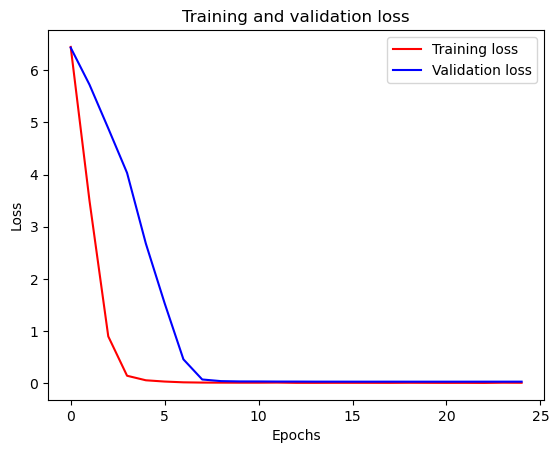

In [9]:
plt.plot( t_loss, 'r', label='Training loss')
plt.plot(v_loss, 'b', label='Validation loss')

# plt.plot(best_epoch_train_loss, 'g', label='Best loss')
# plt.plot( train_loss_arr, 'r', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
torch.save(model.state_dict(), 'best_model/modelv303.pt')

In [11]:
model_state_dict = torch.load('best_model/modelv303.pt')

# model_state_dict = torch.load('best_model/modelv301.pt' , map_location=torch.device('cpu'))    ##for cpu only

model_ft = models.mobilenet_v3_small(pretrained=False)

# num_ftrs = model_ft.fc.in_features

# model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft.load_state_dict(model_state_dict)
model_ft.eval()
model_ft.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [12]:
# Define a transformation to preprocess the image
pred_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define a function for making predictions
def predict_class(image_path):

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    
    # Apply the defined transformation
    image_tensor = pred_transform(Image.fromarray(image))
    image_tensor = image_tensor.unsqueeze(0)  # Add a batch dimension
    
    # Move the input image to the same device as the model
    image_tensor = image_tensor.to(device)
    
    # Make a prediction
    with torch.no_grad():
        outputs = model_ft(image_tensor)
    
    # Get the predicted class index
    _, predicted_idx = torch.max(outputs, 1)
    
    # Map the class index to the class name (replace 'class_mapping' with your mapping)
    # class_mapping = {0: 'class_0', 1: 'class_1', 2: 'class_2'}  # Replace with your actual class names
    predicted_class = class_names[predicted_idx.item()]
    
    return predicted_class

In [13]:
predict_class("demo_img/1002295.png")

'Signature_card'

In [14]:
val_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_dataset = datasets.ImageFolder('dataset/test', transform=val_transforms)

valloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

In [15]:
true_labels = []
pred_labels = []

with torch.no_grad():
    for images, labels in valloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

cm = confusion_matrix(true_labels, pred_labels)

In [16]:
tp = cm[0, 0]
fp = cm[1, 0]
fn = cm[0, 1]
tn = cm[1, 1]

# Calculate precision, recall, and F1 score
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision.item())
print("Recall:", recall.item())
print("F1 Score:", f1_score.item())

print(tp)
print(fp)
print(fn)
print(tn)

Precision: 0.99
Recall: 0.99
F1 Score: 0.99
198
2
2
198


In [17]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

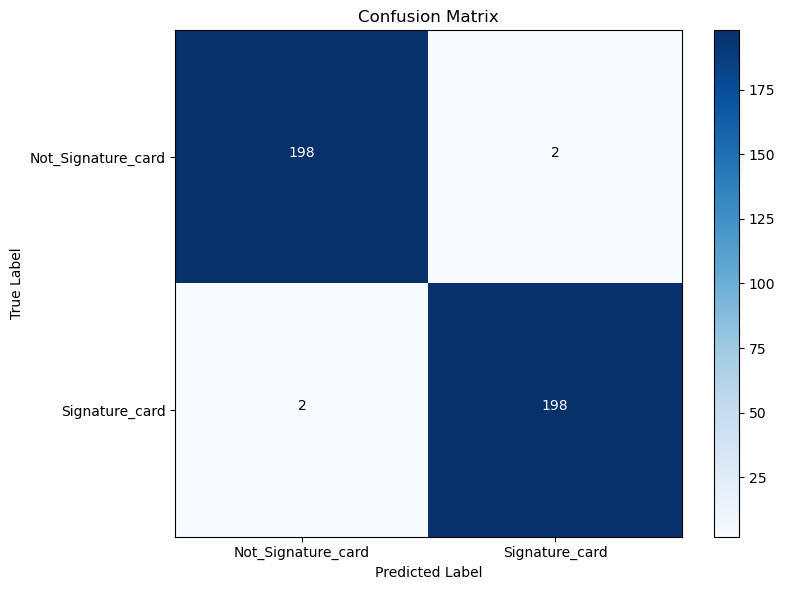

In [18]:
# Example confusion matrix values
confusion_matrix = np.array([[50, 10], [15, 75]])
classes = class_names

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes, normalize=False)
plt.show()

In [21]:
real_label = []
pred_label = []

def evaluate(model, data_loader):
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
#             inputs = FaceCrop(inputs)
#             image_tensor = toTensor(inputs)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            real_label.append(labels.cpu().numpy())
            pred_label.append(predicted.cpu().numpy())
    return correct / total

transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([255,255])
])

tests_path = r'dataset/test'

test_dataloader = DataLoader(
    torchvision.datasets.ImageFolder(tests_path, transform = transformer),
    batch_size = 50
)

In [22]:
accuracy = evaluate(model_ft, test_dataloader)
accuracy


0.34375